# Diart Python Online Notebook

In [1]:
# install pyannote and other dependencies as well from https://github.com/juanmc2005/StreamingSpeakerDiarization
# !pip install diart
# !pip install pyannote.audio
# !pip install wget
# !pip install memory_profiler


- Runs on very low RAM (\~1GB) as opposed to NeMo or pyannote (\~6GB)
- Realtime diarization with metrics
- easy setup
- can be used for almost infintite audio stream, unlike other models which need smaller audio files

<img src="rttm-viewer-demo-AMI.gif" width="750" align="center">

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# CUDA_VISIBLE_DEVICES options = 0/1/2/3. Make sure to restart
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi


2
Sun Jul 31 19:08:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:19:00.0 Off |                  Off |
| 33%   34C    P8    29W / 260W |  24214MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     Off  | 00000000:1A:00.0 Off |                  Off |
| 33% 

In [2]:
import os
import wget
from zipfile import ZipFile
import warnings
import time
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa

from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.database.util import load_rttm

from diart.sources import MicrophoneAudioSource, FileAudioSource
from diart.inference import RealTimeInference
from diart.pipelines import OnlineSpeakerDiarization, PipelineConfig
from diart.inference import Benchmark

%load_ext memory_profiler

warnings.filterwarnings('ignore')

/root/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# get base working dir
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'sample_audio_rttm')

if not os.path.exists(data_dir):
    # download data files if not present
    os.makedirs(data_dir, exist_ok=True)
    print(f"Downloading 5 wavs, 5 rttms into (~121mb): {data_dir}")
    wget.download('https://download1326.mediafire.com/cvcrn1bv231g/0s2w0o8ueda1ret/sample_audio_rttm.zip', ROOT)
    print("Extracting...")
    with ZipFile(ROOT+'/sample_audio_rttm.zip', 'r') as zip_ref:
        zip_ref.extractall(data_dir)

        
# an4_diarize_test.wav, 00:00:05.20    [5 s    ]
# mbzht.wav, 00:02:10.82               [2 min  ]
# jttar.wav, 00:10:43.58               [10 min ]
# IS1009c.Mix-Headset.wav, 00:30:20.83 [30 min ]
# EN2002c.Mix-Headset.wav, 00:49:32.26 [50 min ]

# setup audio and rttm filepath
URI_LIST = ['an4', 'mbzht', 'jttar', 'IS1009c.Mix-Headset', 'EN2002c.Mix-Headset']
AUDIO_LIST = ['an4_diarize_test.wav', 'mbzht.wav', 'jttar.wav', 'IS1009c.Mix-Headset.wav', 'EN2002c.Mix-Headset.wav']
RTTM_LIST = ['an4_diarize_test.rttm', 'mbzht.rttm', 'jttar.rttm', 'IS1009c.Mix-Headset.rttm', 'EN2002c.Mix-Headset.rttm']

"""
ONLY NEED TO CHANGE idx = 0,1,2,3,4
"""
idx = 1


audio_uri = URI_LIST[idx]
audio_file = AUDIO_LIST[idx]
rttm_file =  RTTM_LIST[idx] #  loads a dictionary of label:rttm
audio_file = os.path.join(data_dir, audio_file)
rttm_file = os.path.join(data_dir, rttm_file)

    
print(f"[{os.getpid()}] Loaded audio: {audio_file}\n")
!head {rttm_file}

[10154] Loaded audio: /home/DATA/amit_kesari/SD1/diart/sample_audio_rttm/mbzht.wav

SPEAKER mbzht 1 0.04000 3.23000 <NA> <NA> spk00 <NA> <NA>
SPEAKER mbzht 1 3.69000 10.75000 <NA> <NA> spk01 <NA> <NA>
SPEAKER mbzht 1 14.60000 4.32000 <NA> <NA> spk02 <NA> <NA>
SPEAKER mbzht 1 19.02000 9.30000 <NA> <NA> spk01 <NA> <NA>
SPEAKER mbzht 1 28.38000 2.02000 <NA> <NA> spk00 <NA> <NA>
SPEAKER mbzht 1 30.66000 19.30000 <NA> <NA> spk01 <NA> <NA>
SPEAKER mbzht 1 49.82000 10.82000 <NA> <NA> spk03 <NA> <NA>
SPEAKER mbzht 1 58.79000 3.03000 <NA> <NA> spk00 <NA> <NA>
SPEAKER mbzht 1 61.36000 0.50000 <NA> <NA> spk03 <NA> <NA>
SPEAKER mbzht 1 61.60000 12.28000 <NA> <NA> spk01 <NA> <NA>


## From python notebook interface for recorded conversation

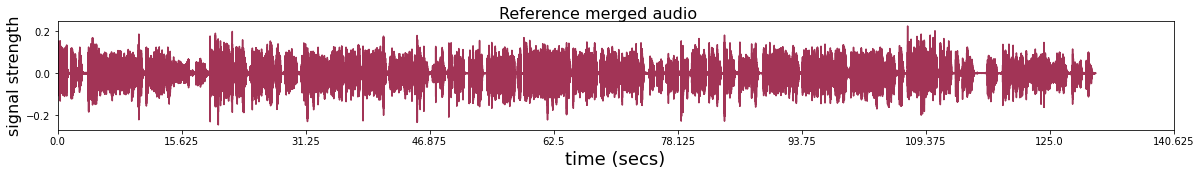

In [4]:
sr = 16000
signal, sr = librosa.load(audio_file,sr=sr) 

# plot and listen to the audio and visualize the tracks
fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'#a23456')
fig.suptitle('Reference merged audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);
plt.show()


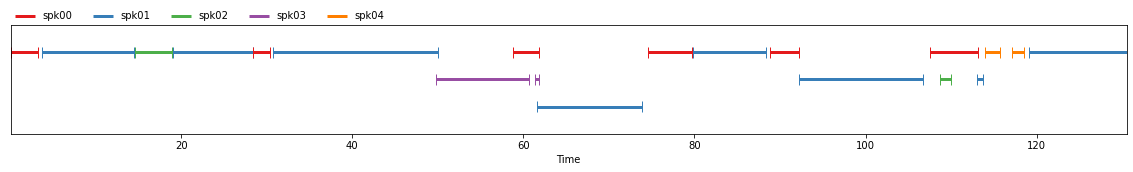

In [5]:
out_dir = os.path.join(data_dir, 'pred_rttms')
os.makedirs(out_dir, exist_ok=True)

# load groundtruth
groundtruth = load_rttm(rttm_file) # this is a dict for groundtruth rttm db
groundtruth = groundtruth[audio_uri] # get groundtruth of DEMO_FILE

# visualize groundtruth
groundtruth
# This nice visualization is by pyannote.core and basically indicates when each speaker speaks.
# SPEAKER {file_name} 1 {start_time} {duration} <NA> <NA> {speaker_name} <NA> <NA>

In [6]:

# load audio waveform
display(Audio(audio_file, rate=16000))

# TODO: tune and sync both!
# You can do 2x audio for now

Starting Stream...Click Audio in 5s


Streaming mbzht:   0%|          | 1/253 [00:00<00:40,  6.16it/s]

<IPython.core.display.Javascript object>


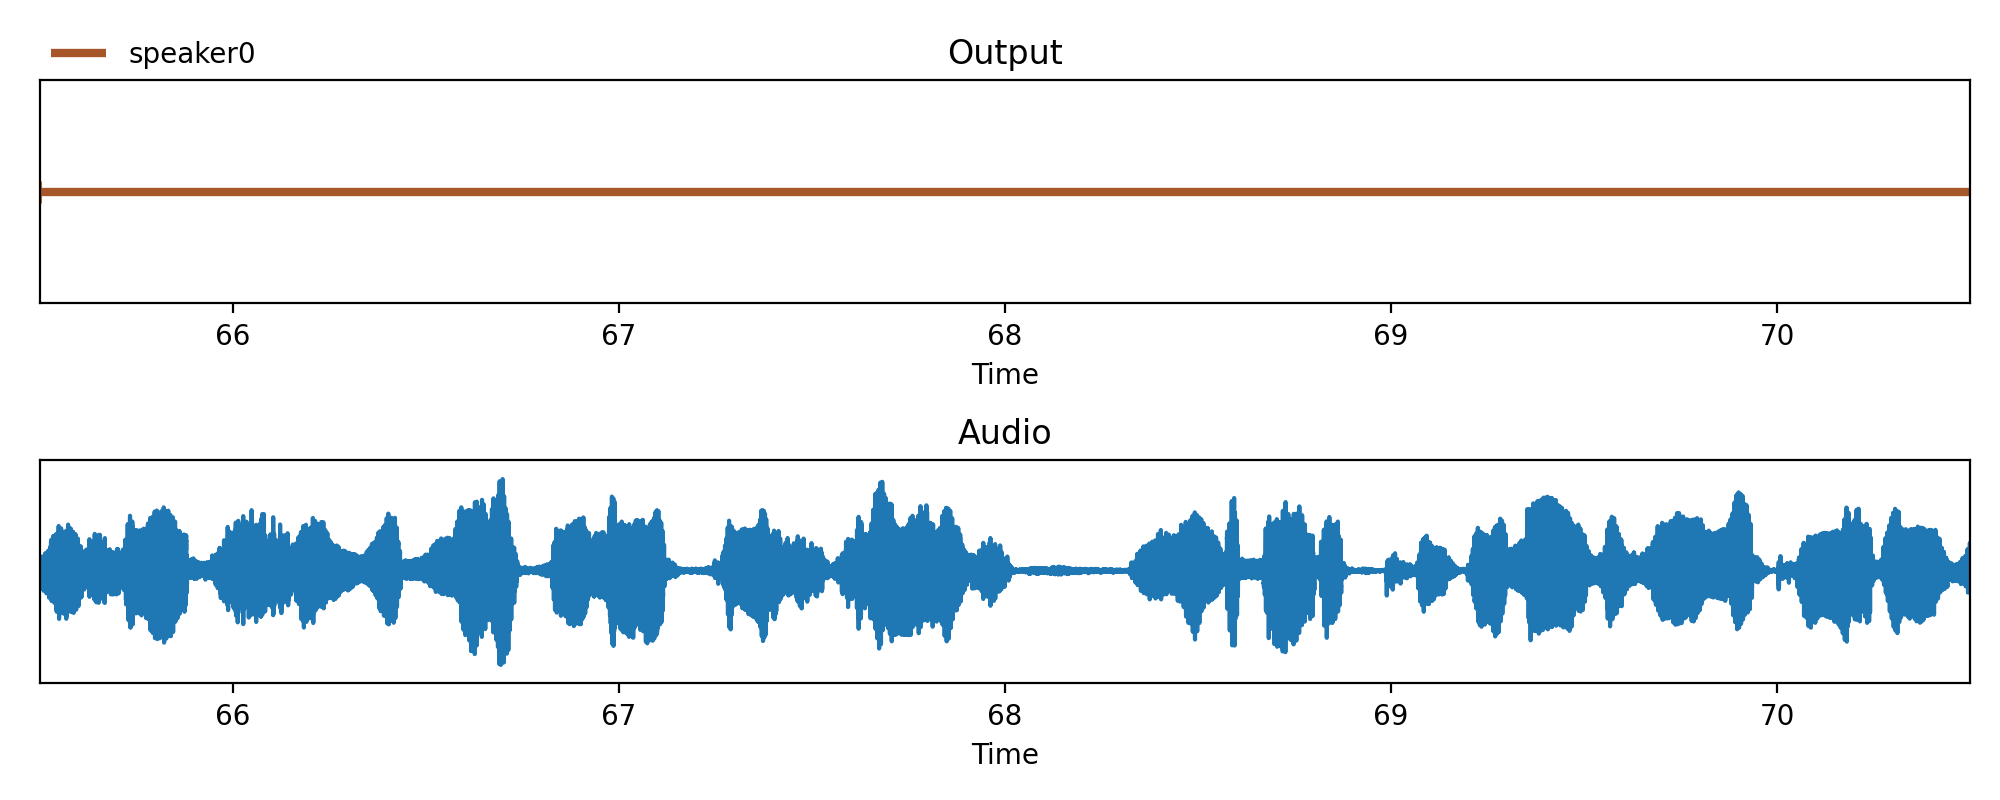

Streaming mbzht:  53%|█████▎    | 133/253 [00:37<00:34,  3.52it/s]

KeyboardInterrupt: 

In [7]:
# %%memit
%matplotlib notebook

## initalise the streaming pipeline!
# config = PipelineConfig()  # Default parameters
config = PipelineConfig(
    step=0.5,
    latency=0.5,
    tau_active=0.555,
    rho_update=0.422,
    delta_new=1.517
)
pipeline = OnlineSpeakerDiarization(config)

audio_source = FileAudioSource(audio_file, config.sample_rate, config.duration, config.step)

## if using a mic:
# audio_source = MicrophoneAudioSource(config.sample_rate)

inference = RealTimeInference(out_dir, do_plot=True)

print("Starting Stream...Click Audio in 5s")
time.sleep(5)
# %timeit -n 1 -r 1 
inference(pipeline, audio_source)

In [ ]:
# Benchmark
from diart.inference import Benchmark
from diart.pipelines import OnlineSpeakerDiarization, PipelineConfig

config = PipelineConfig(
    step=0.5,
    latency=0.5,
    tau_active=0.555,
    rho_update=0.422,
    delta_new=1.517
)
pipeline = OnlineSpeakerDiarization(config)

wav_dir = os.path.join(data_dir, 'ami_mix_headset/wav/test')
rttm_dir = os.path.join(data_dir, 'ami_mix_headset/rttms/test')
out_dir = os.path.join(ROOT, 'out')
benchmark = Benchmark(wav_dir, rttm_dir, out_dir)

benchmark(pipeline)

## From the command line

In [ ]:
# runs SSD and generates the rttm file
!python -m diart.stream --output {out_dir} {audio_file} 


In [ ]:
# Find DER using pyannote metircs
# load groundtruth
from pyannote.database.util import load_rttm
from pyannote.metrics.diarization import DiarizationErrorRate

groundtruth = load_rttm(rttm_file) # this is a dict for rttm db
groundtruth = groundtruth[audio_uri] # get groundtruth of DEMO

# visualize groundtruth
groundtruth
# This nice visualization is by pyannote.core and basically indicates when each speaker speaks.
# SPEAKER {file_name} 1 {start_time} {duration} <NA> <NA> {speaker_name} <NA> <NA>

In [ ]:
# load hypothesis that we got from diart

out_rttm_file = os.path.join(out_dir, audio_uri+'.rttm')
print("Loaded hypothesis rttm from ", out_rttm_file)
hypothesis = load_rttm(out_rttm_file) # this is generated above by diart
hypothesis = hypothesis[audio_uri] # get groundtruth of DEMO

# visualize groundtruth
hypothesis



In [ ]:
# get DER by comparing groundtruth and hypothesis generated by model
metric = DiarizationErrorRate()
der = metric(groundtruth, hypothesis)
print(f'diarization error rate  = {100 * der:.1f}%')

# Sync both audio and spectrogram

In [ ]:
from scipy.signal import spectrogram
import holoviews as hv 
import panel as pn
from scipy.io import wavfile

def sync_audio_spec(audio_file):
    hv.extension("bokeh", logo=False)

    e = 10**-8 # for non-zero

    sr, wav_data = wavfile.read(audio_file)
    # audio is of one channel right now
    # audio_data = wav_data[:,0] # first channel
    audio_data = wav_data 
    f, t, sxx = spectrogram(audio_data, sr)
    # print(f, t, sxx )
    
    spec_gram = hv.Image((t, f, 10*np.log10(sxx+e)), ["Time (s)", "Frequency (hz)"]).opts(width=900)
    audio = pn.pane.Audio(wav_data, sample_rate=sr, name='Audio', throttle=500)

    def update_playhead(x,y,t):
        """
        playhead to update when the time changes while you're playing it.
        links a stream with a callback function, through dmap_time.
        """
        if x is None:
            return hv.VLine(t).opts(color='white')
        else:
            audio.time = x
            return hv.VLine(x).opts(color='white')

    # to click the plot and update the playhead as well
    tap_stream = hv.streams.SingleTap(transient=True)
    time_play_stream = hv.streams.Params(parameters=[audio.param.time], rename={'time': 't'})
    dmap_time = hv.DynamicMap(update_playhead, streams=[time_play_stream, tap_stream])

    # * operator to overlay the image with the returned Vline playhead
    # pn.Column displays audio on top of spectrogram
    out = pn.Column( audio, 
                   (spec_gram * dmap_time))
    display(out)

    
# show and sync both audio and spectrogram
sync_audio_spec(audio_file)